In [1]:
cd ..

c:\Users\mwynn\repos\AK-ZtH-building-makemore


In [ ]:
import random

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
words = open("data/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [277]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [ ]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embd)                    , generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)*((n_embd * block_size)**-0.5)
# b1 = torch.randn(n_hidden                       , generator=g) * 0.01  # not needed as using batch norm straight after hidden layer
W2 = torch.randn((n_hidden, 27)                 , generator=g) * 0.01
b2 = torch.randn(27                             , generator=g) * 0.0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [335]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # (BATCH_SIZE, BLOCK_SIZE), (BATCH_SIZE,)

    # forward pass
    emb = C[Xb]  # (BATCH_SIZE, BLOCK_SIZE, EMBEDDING_SIZE)
    embcat = emb.view(emb.shape[0], -1)  # (BATCH_SIZE, BLOCK_SIZE * EMBEDDING_SIZE)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / (bnstdi + 1e-5) + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}  lr={lr:.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2820  lr=0.1000
  10000/ 200000: 2.4278  lr=0.1000
  20000/ 200000: 2.3188  lr=0.1000
  30000/ 200000: 2.1798  lr=0.1000
  40000/ 200000: 2.1292  lr=0.1000
  50000/ 200000: 2.0417  lr=0.1000
  60000/ 200000: 1.8676  lr=0.1000
  70000/ 200000: 2.2485  lr=0.1000
  80000/ 200000: 2.0067  lr=0.1000
  90000/ 200000: 2.1579  lr=0.1000
 100000/ 200000: 2.0240  lr=0.0100
 110000/ 200000: 2.0519  lr=0.0100
 120000/ 200000: 2.1314  lr=0.0100
 130000/ 200000: 2.0662  lr=0.0100
 140000/ 200000: 1.7506  lr=0.0100
 150000/ 200000: 2.1650  lr=0.0100
 160000/ 200000: 1.7519  lr=0.0100
 170000/ 200000: 1.9192  lr=0.0100
 180000/ 200000: 2.2092  lr=0.0100
 190000/ 200000: 1.8819  lr=0.0100


In [315]:
# plt.figure(figsize=(20, 10))
# plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [319]:
# plt.hist(h.view(-1).tolist(), 50);

In [320]:
# plt.hist(hpreact.view(-1).tolist(), 50);

In [336]:
# plt.plot(range(max_steps), lossi)

In [337]:
# # Calibrate the batch norm at the end of training

# with torch.no_grad():
#     # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # measure the mean/std over the entire trainings set
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)

In [350]:
# Evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss("train")
split_loss("val")

train 2.0649166107177734
val 2.117743730545044


In [352]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carlaizlailia.
khi.
milia.
aty.
skanden.
jazzubefaresara.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
joce.
quint.
shoisea.
jadiquinte.
madiaryni.
jaxen.
dus.
bren.
emiia.


In [354]:
# plt.figure(figsize=(8, 8))
# plt.scatter(C[:,0].data, C[:,1].data, s=200)
# for i in range(C.shape[0]):
#     plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
# plt.grid('minor')

Pytorch-ified code below with deeper network

In [ ]:
class Linear:

    def __init__(self, fan_in: int, fan_out: int, bias: bool = True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [364]:
class BatchNorm1d:

    def __init__(self, dim: int, eps: float = 1e-5, momentum: float=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers that are not trained with backprop
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [365]:
class Tanh:
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [422]:
vocab_size = len(stoi)
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [423]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # (BATCH_SIZE, BLOCK_SIZE), (BATCH_SIZE,)

    # forward pass
    emb = C[Xb]  # (BATCH_SIZE, BLOCK_SIZE, EMBEDDING_SIZE)
    x = emb.view(emb.shape[0], -1)  # (BATCH_SIZE, BLOCK_SIZE * EMBEDDING_SIZE)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)  # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()  # AFTER_DEBUG: would take out
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}  lr={lr:.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i == 1000:
        break  # AFTER_DEBUG: would take out

      0/ 200000: 3.3001  lr=0.1000


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.25%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.69%
layer 8 (      Tanh): mean +0.00, std 0.65, saturated: 2.22%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.94%
layer 14 (      Tanh): mean +0.01, std 0.65, saturated: 2.00%


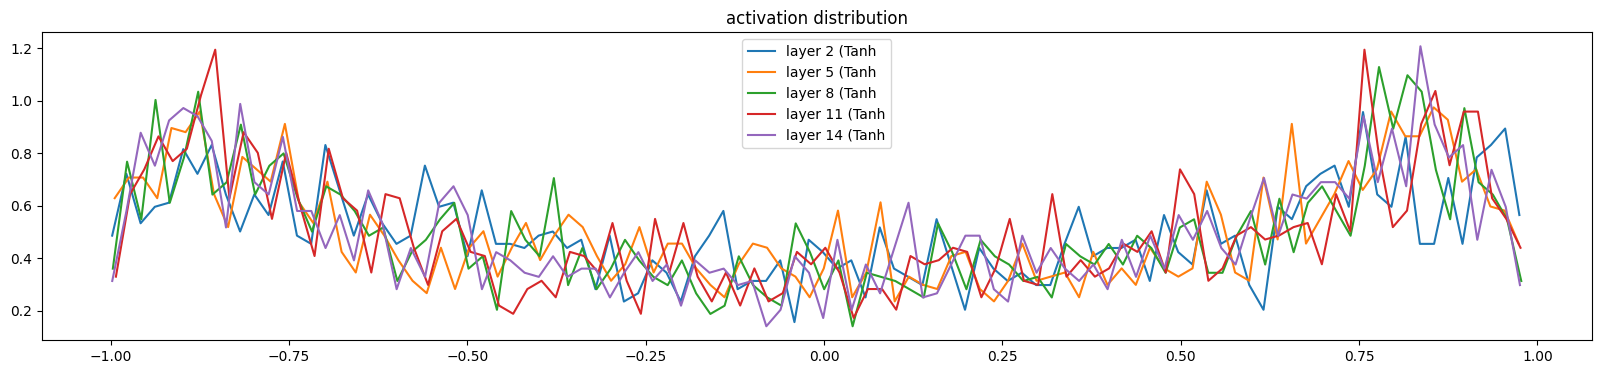

In [424]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


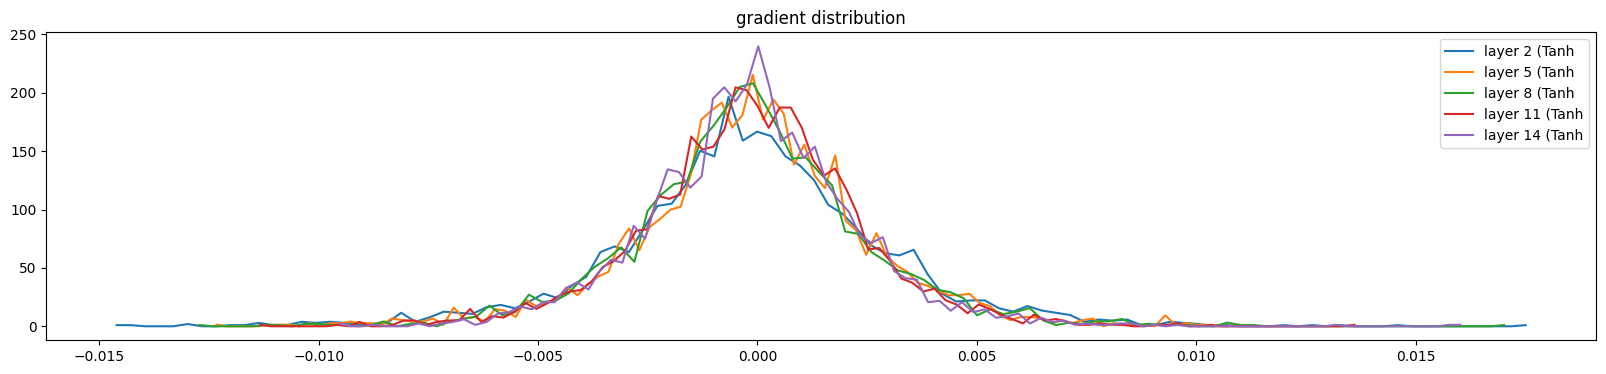

In [425]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 7.330813e-03 | grad:data ratio 7.323332e-03
weight  (30, 100) | mean -0.000073 | std 6.452614e-03 | grad:data ratio 2.064336e-02
weight (100, 100) | mean +0.000069 | std 5.609042e-03 | grad:data ratio 3.354886e-02
weight (100, 100) | mean +0.000102 | std 4.720696e-03 | grad:data ratio 2.798932e-02
weight (100, 100) | mean +0.000030 | std 4.693332e-03 | grad:data ratio 2.796335e-02
weight (100, 100) | mean +0.000009 | std 4.399413e-03 | grad:data ratio 2.620319e-02
weight  (100, 27) | mean +0.000039 | std 8.465442e-03 | grad:data ratio 5.077295e-02


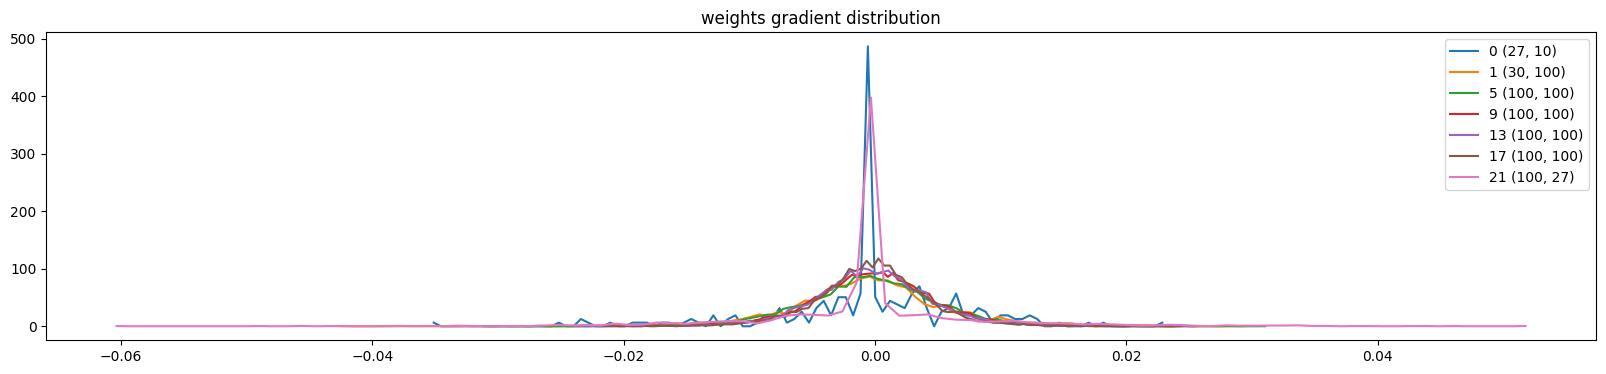

In [426]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

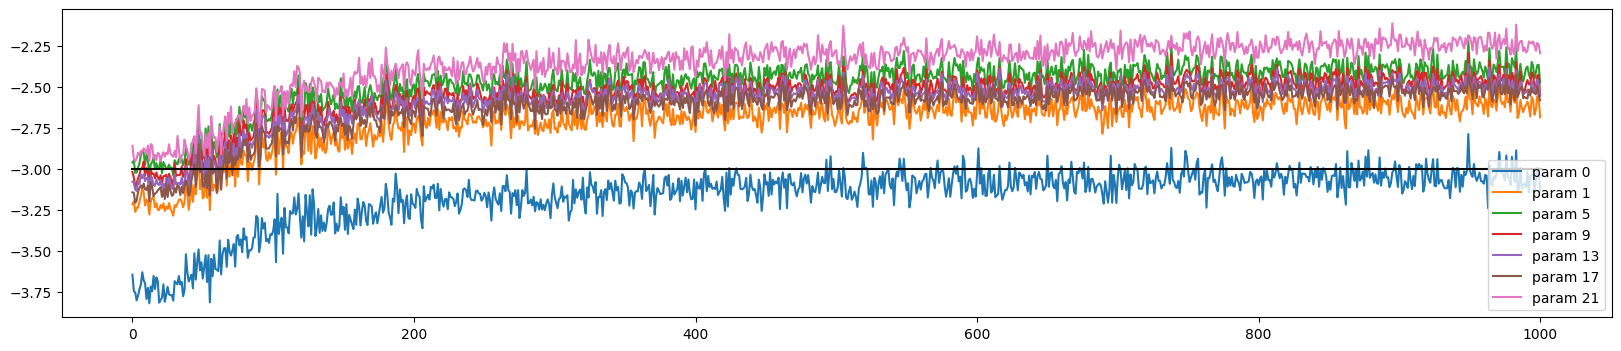

In [427]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);